PLA converged after 10000 updates.
Test Accuracy: 0.5266


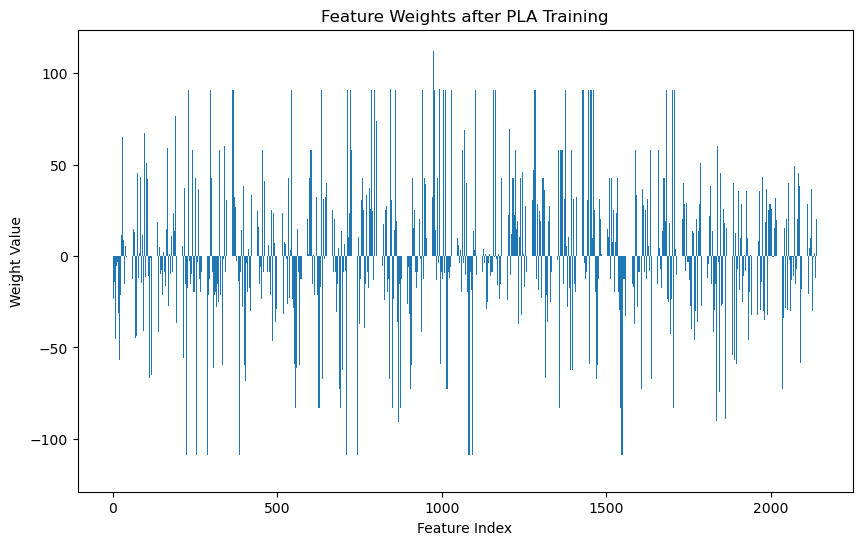

In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = pd.read_csv('../split_data/train_test_data.csv')
test_data = pd.read_csv('../split_data/validation_data.csv')

def preprocess_data(train_data, test_data):
    # Define target column
    target = 'home_team_win'

    # Drop non-predictive or unnecessary columns
    drop_cols = ['id', 'date']
    train_data = train_data.drop(columns=drop_cols, errors='ignore')
    test_data = test_data.drop(columns=drop_cols, errors='ignore')

    # Handle categorical features with consistent one-hot encoding
    combined_data = pd.concat([train_data, test_data], axis=0)
    combined_data = pd.get_dummies(combined_data, columns=combined_data.select_dtypes(include=['object']).columns, drop_first=True)

    # Split back into train and test
    train_data = combined_data.iloc[:len(train_data)]
    test_data = combined_data.iloc[len(train_data):]

    # Separate features and target
    features = [col for col in train_data.columns if col != target]
    X_train = train_data[features].fillna(0)
    y_train = train_data[target].map({True: 1, False: -1})

    X_test = test_data[features].fillna(0)
    y_test = test_data[target].map({True: 1, False: -1})

    return X_train.values, y_train.values, X_test.values, y_test.values

# Preprocess train and test data
X_train, y_train, X_test, y_test = preprocess_data(train_data, test_data)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# PLA function
def pla(x, y, max_iterations=10000):
    w = np.zeros(x.shape[1])  # Initialize weight vector
    updates = 0
    consecutive_correct = 0

    while True:
        # Randomly select an example
        i = random.randint(0, len(y) - 1)
        x_i, y_i = x[i], y[i]
        
        # Check if classification is correct
        if np.sign(np.dot(w, x_i)) != y_i:
            # Update weights
            w += y_i * x_i
            updates += 1
            consecutive_correct = 0  # Reset consecutive correct checks
        else:
            consecutive_correct += 1
        
        # Stop if we've checked max_iterations samples or 5N consecutive correct predictions
        if consecutive_correct >= 5 * len(y) or updates >= max_iterations:
            break
    
    return w, updates

# Train PLA on training data
w, updates = pla(X_train, y_train)

print(f"PLA converged after {updates} updates.")

# Test the model
def predict(x, w):
    return np.sign(np.dot(x, w))

y_pred = predict(X_test, w)

# Evaluate the performance
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualization
def plot_weights(w):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(w)), w)
    plt.title("Feature Weights after PLA Training")
    plt.xlabel("Feature Index")
    plt.ylabel("Weight Value")
    plt.show()

plot_weights(w)
